In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
import time
from island_ga import IslandGGA 
from chromosome import Chromosome 
from data_preprocessing import Data
import itertools
import yfinance as yf
import datetime
from single_data_processing import SingleAssetTI

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


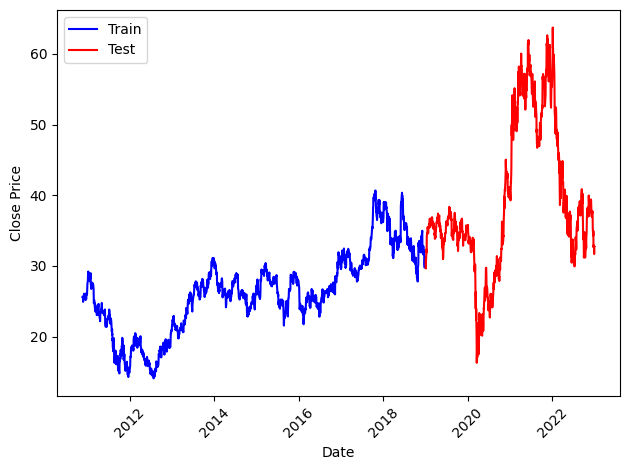

In [2]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
period ="train"
ticker = 'GM'
data = SingleAssetTI(ticker, start_date, end_date,2019)
data.data_preprocess()
train_data = data.train_data    
val_data = data.test_data

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

evolve_strategy = ["ring", "multikuti", "master_slave", "nearest","random","fully_connected"]
evolve_strategy = ["ring", "multikuti", "master_slave", "gga"]
num_runs = 10
all_records = []

for strategy in evolve_strategy:
    if strategy == 'gga':
        num_islands = 1
        pop_size = 150
    else:
        num_islands = 5
        pop_size = 150

    for run in range(num_runs):

        
        ga = IslandGGA(
            data=data.train_data,
            K=2,
            num_islands=num_islands,
            m_iter=5,
            num_iter=100,
            pSize=pop_size,
            strategies=data.strategies,
            evolve_strategy=strategy
        )
        ga.evolve()
        convergence = ga.diversity_data  # assume it's a list of values over time

        for t, val in enumerate(convergence, start=1):
            all_records.append({
                'strategy': strategy,
                'run': run,
                'iteration': t,
                'diversity': val
            })

# Convert to DataFrame
df_diversity = pd.DataFrame(all_records)

# Save for inspection
df_diversity.to_csv("results/convergence_diversity.csv", index=False)


Running ring
Generation 1: Best fitness = 1.2304034901292262  Average Fitness = 1.2238280545833964
Generation 2: Best fitness = 1.2304034901292262  Average Fitness = 1.2247792564753865
Generation 3: Best fitness = 1.2304034901292262  Average Fitness = 1.2293075842049217
Generation 4: Best fitness = 1.2304034901292262  Average Fitness = 1.2304034901292267
Generation 5: Best fitness = 1.2304034901292262  Average Fitness = 1.2304034901292267
Island 0 Migration - Left 4 - Right 1
Island 1 Migration - Left 0 - Right 2
Island 2 Migration - Left 1 - Right 3
Island 3 Migration - Left 2 - Right 4
Island 4 Migration - Left 3 - Right 0
Generation 6: Best fitness = 1.2304034901292262  Average Fitness = 1.2293075842049217
Generation 7: Best fitness = 1.2304034901292262  Average Fitness = 1.2304034901292267
Generation 8: Best fitness = 1.2304034901292262  Average Fitness = 1.2282116782806167
Generation 9: Best fitness = 1.2304034901292262  Average Fitness = 1.2304034901292267
Generation 10: Best fit

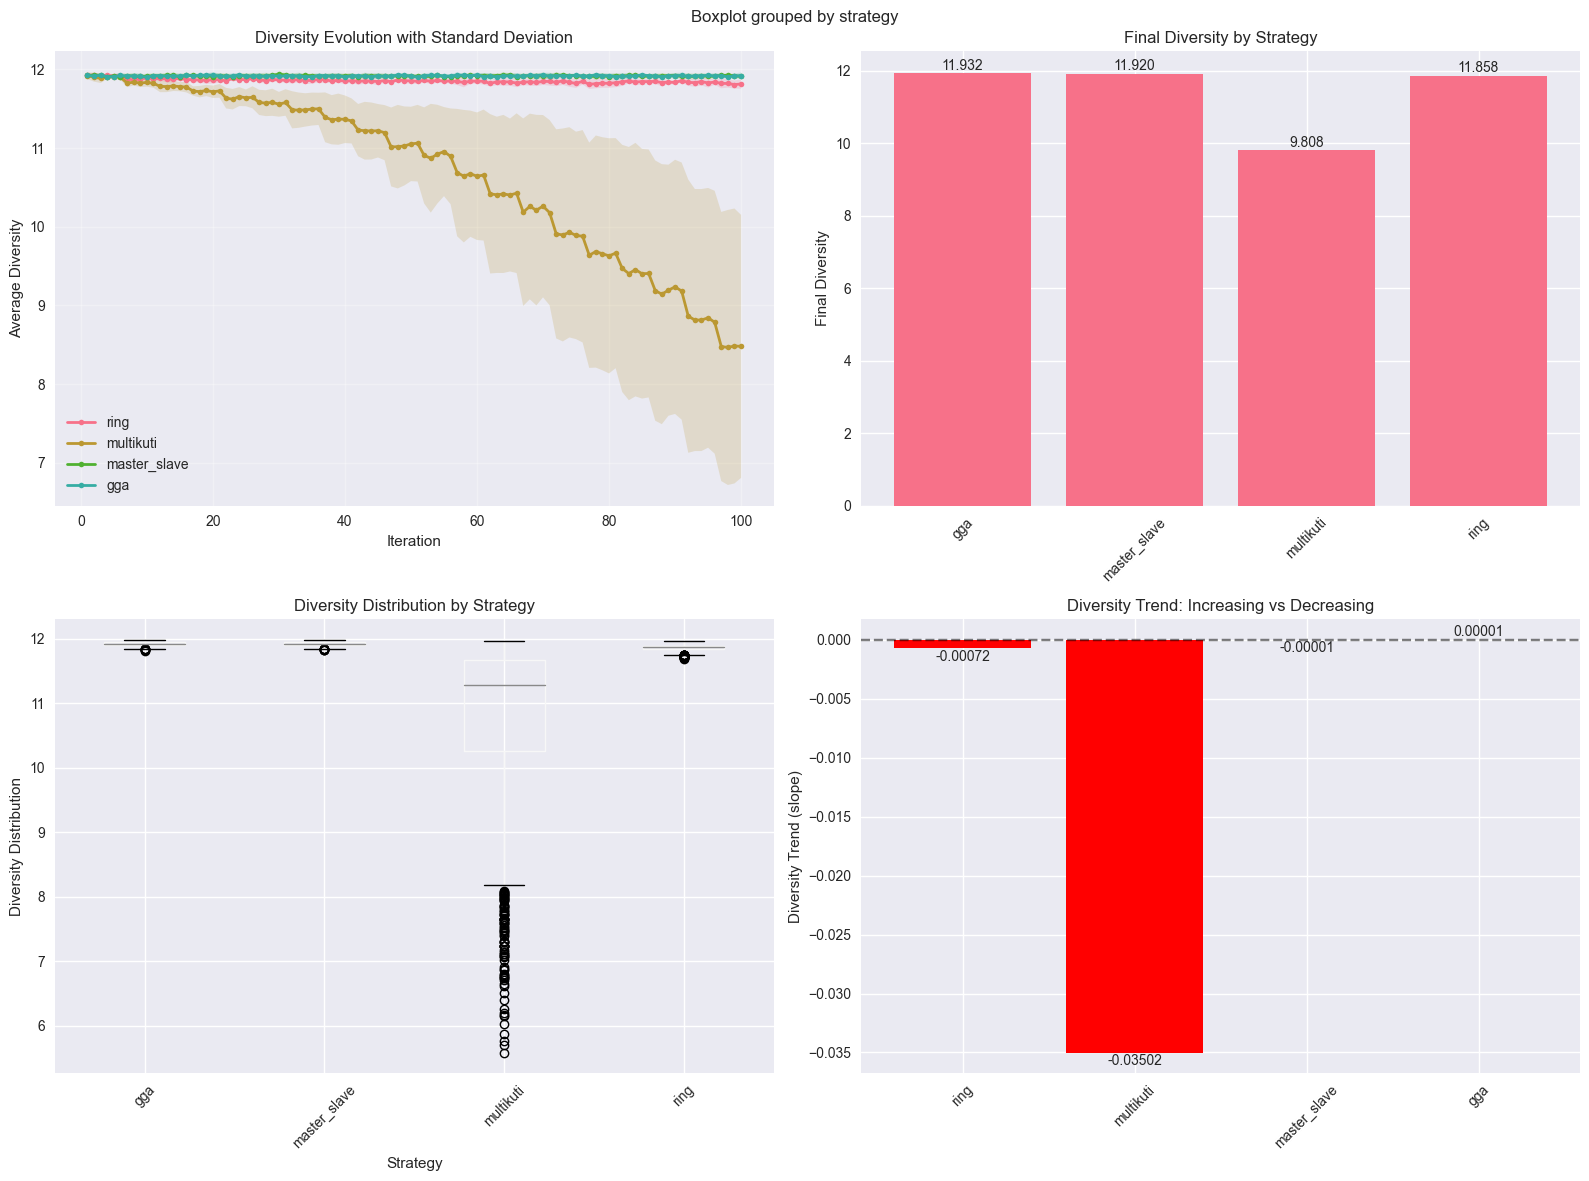

=== Diversity Analysis Summary ===

Final Diversity by Strategy:
                 mean     std      min      max
strategy                                       
gga           11.9181  0.0287  11.8019  11.9803
master_slave  11.9183  0.0294  11.8151  11.9785
multikuti     10.6964  1.3850   5.5807  11.9694
ring          11.8562  0.0451  11.6809  11.9652

Diversity Trends (positive = increasing, negative = decreasing):
ring: -0.000716 (STABLE)
multikuti: -0.035016 (DECREASING)
master_slave: -0.000010 (STABLE)
gga: 0.000015 (STABLE)


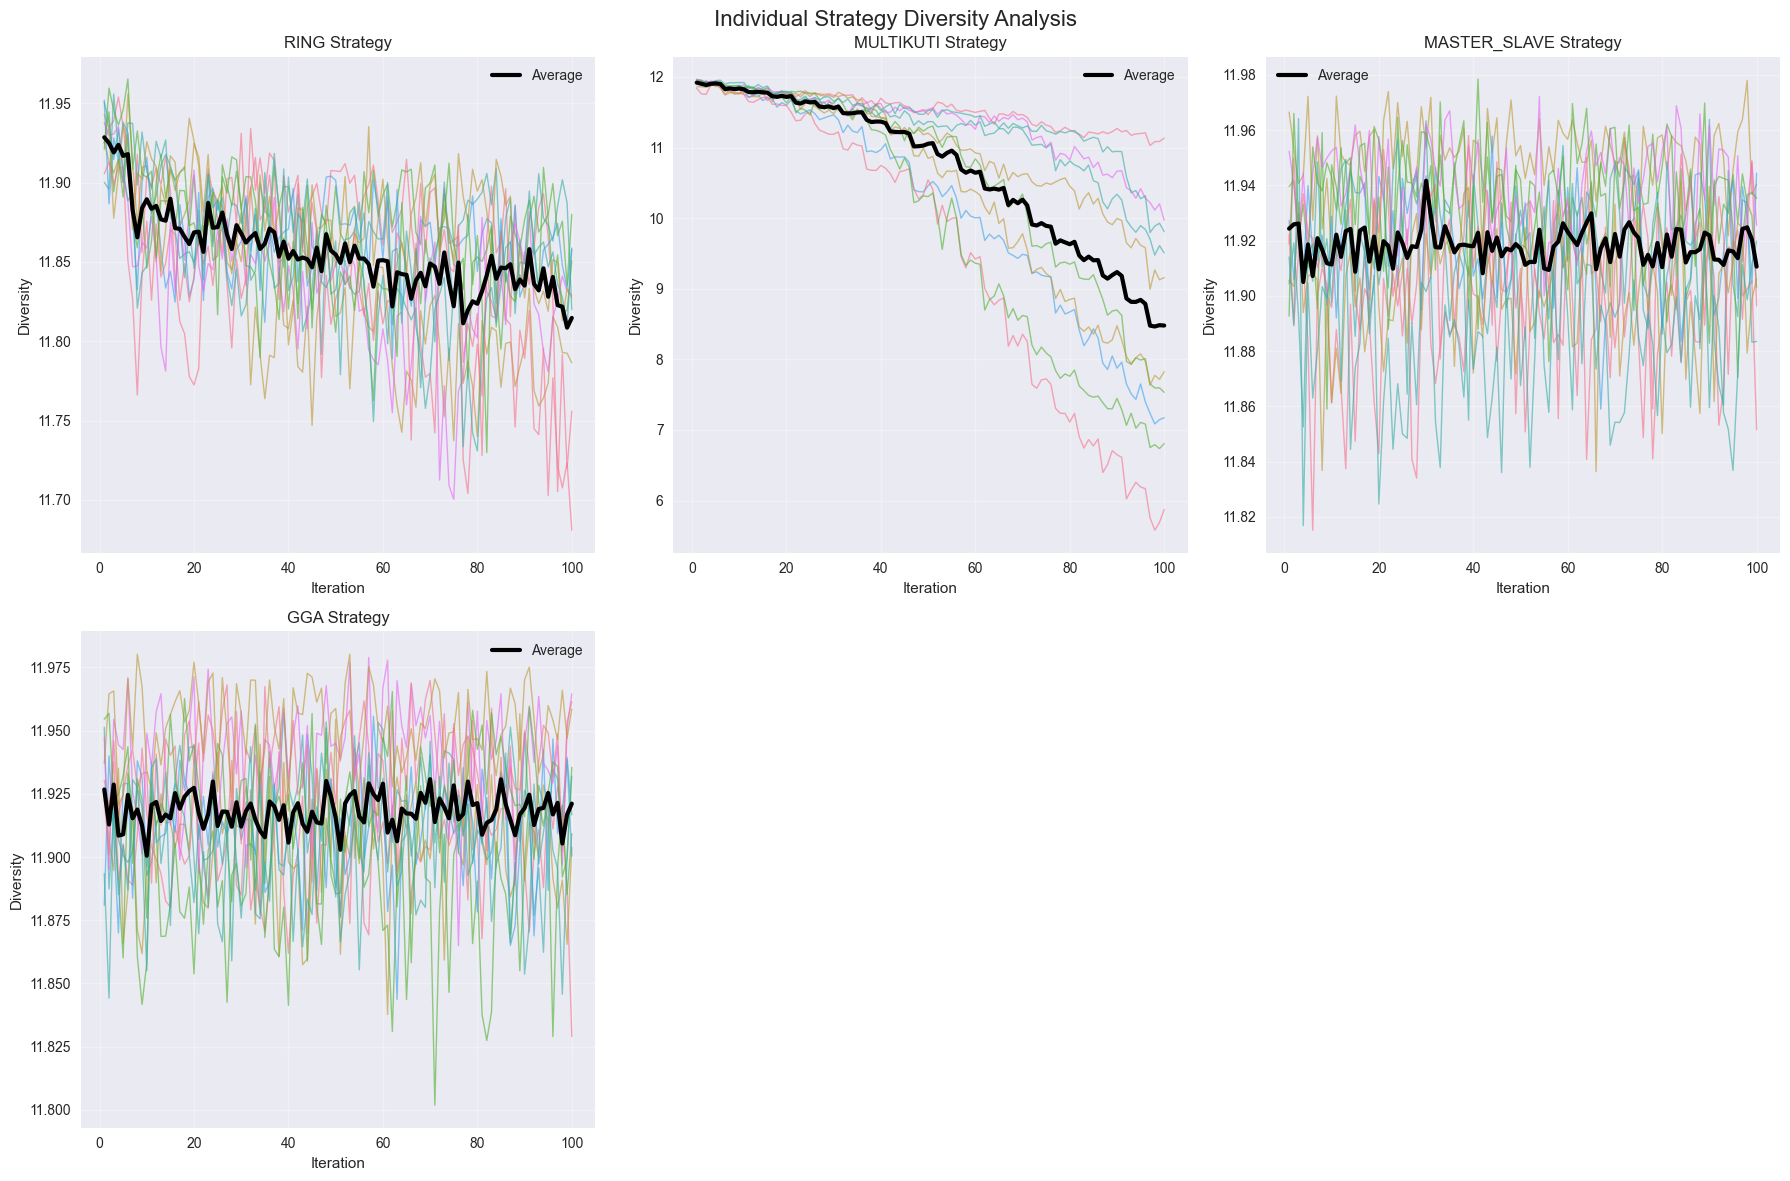

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the diversity data
df_diversity = pd.read_csv("results/convergence_diversity.csv")

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create comprehensive diversity plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Population Diversity Analysis by Migration Strategy', fontsize=16, fontweight='bold')

# Plot 1: Average diversity over iterations by strategy
ax1 = axes[0, 0]
for strategy in df_diversity['strategy'].unique():
    strategy_data = df_diversity[df_diversity['strategy'] == strategy]
    avg_diversity = strategy_data.groupby('iteration')['diversity'].mean()
    std_diversity = strategy_data.groupby('iteration')['diversity'].std()
    
    ax1.plot(avg_diversity.index, avg_diversity.values, 
             label=strategy, marker='o', linewidth=2, markersize=4)
    ax1.fill_between(avg_diversity.index, 
                     avg_diversity.values - std_diversity.values,
                     avg_diversity.values + std_diversity.values,
                     alpha=0.2)

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Average Diversity')
ax1.set_title('Diversity Evolution with Standard Deviation')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Final diversity comparison
ax2 = axes[0, 1]
final_diversity = df_diversity.groupby('strategy')['diversity'].last()
bars = ax2.bar(final_diversity.index, final_diversity.values)
ax2.set_ylabel('Final Diversity')
ax2.set_title('Final Diversity by Strategy')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, value in zip(bars, final_diversity.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

# Plot 3: Diversity distribution (box plot)
ax3 = axes[1, 0]
df_diversity.boxplot(column='diversity', by='strategy', ax=ax3)
ax3.set_xlabel('Strategy')
ax3.set_ylabel('Diversity Distribution')
ax3.set_title('Diversity Distribution by Strategy')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# Plot 4: Diversity trends (slope analysis)
ax4 = axes[1, 1]
diversity_trends = []
strategy_names = []

for strategy in df_diversity['strategy'].unique():
    strategy_data = df_diversity[df_diversity['strategy'] == strategy]
    avg_diversity = strategy_data.groupby('iteration')['diversity'].mean()
    
    # Calculate trend (slope)
    if len(avg_diversity) > 1:
        iterations = avg_diversity.index.values
        diversities = avg_diversity.values
        slope = np.polyfit(iterations, diversities, 1)[0]
        diversity_trends.append(slope)
        strategy_names.append(strategy)

colors = ['green' if trend >= 0 else 'red' for trend in diversity_trends]
bars = ax4.bar(strategy_names, diversity_trends, color=colors)
ax4.set_ylabel('Diversity Trend (slope)')
ax4.set_title('Diversity Trend: Increasing vs Decreasing')
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax4.tick_params(axis='x', rotation=45)

# Add value labels
for bar, value in zip(bars, diversity_trends):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.0001 if value >= 0 else -0.0001),
             f'{value:.5f}', ha='center', va='bottom' if value >= 0 else 'top')

plt.tight_layout()
plt.savefig("results/diversity_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("=== Diversity Analysis Summary ===")
print("\nFinal Diversity by Strategy:")
final_stats = df_diversity.groupby('strategy')['diversity'].agg(['mean', 'std', 'min', 'max']).round(4)
print(final_stats)

print("\nDiversity Trends (positive = increasing, negative = decreasing):")
for strategy, trend in zip(strategy_names, diversity_trends):
    trend_desc = "INCREASING" if trend > 0.001 else "DECREASING" if trend < -0.001 else "STABLE"
    print(f"{strategy}: {trend:.6f} ({trend_desc})")

# Create a separate detailed plot for each strategy
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 12))
fig2.suptitle('Individual Strategy Diversity Analysis', fontsize=16)

strategies = df_diversity['strategy'].unique()
for i, strategy in enumerate(strategies):
    row = i // 3
    col = i % 3
    ax = axes2[row, col]
    
    strategy_data = df_diversity[df_diversity['strategy'] == strategy]
    
    # Plot each run separately
    for run in strategy_data['run'].unique():
        run_data = strategy_data[strategy_data['run'] == run]
        ax.plot(run_data['iteration'], run_data['diversity'], 
                alpha=0.6, linewidth=1)
    
    # Plot average
    avg_diversity = strategy_data.groupby('iteration')['diversity'].mean()
    ax.plot(avg_diversity.index, avg_diversity.values, 
            color='black', linewidth=3, label='Average')
    
    ax.set_title(f'{strategy.upper()} Strategy')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Diversity')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Hide empty subplots if needed
for i in range(len(strategies), 6):
    row = i // 3
    col = i % 3
    axes2[row, col].set_visible(False)

plt.tight_layout()
#plt.savefig("results/individual_strategy_diversity.png", dpi=300, bbox_inches='tight')
plt.show()

